# WorldWarBot

I recently found out about [WorldWarBot](https://worldwarbot.com/about/), a totally random simulation of a world war. So let's do out own version!

The rules are simple:
 1. Each round a new province is chosen. Let's call it ATTA
 2. We then choose a random province that borders the empire which contais ATTA. Let's call this province DEFF
 3. ATTA's empire now owns DEFF

In [1]:
from libpysal.weights.contiguity import Rook
from scipy.stats import chisquare
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import numpy as np
import time

%matplotlib inline

## My home city map

I downloaded the map file from my home city's website. It is divided into 487 neighborhoods, which will be our provinces in this simulation. The data also has population and area for each province, but it won't be used.

In [57]:
gdf = gpd.read_file("Data/BH/mygeodata/Bairros_2014-polygon.shp", encoding='latin-1').iloc[:,[0,4,6,7,9]]
gdf.columns = ['Nome', 'População 2010', 'Domicílios 2010', 'Área Km2', 'geometry']
gdf['Nome'] = gdf['Nome'].apply(lambda x: x.encode('latin-1').decode())
gdf['População 2010'] = gdf['População 2010'].apply(lambda x: int(x.replace('.', '')))
gdf['Área Km2'] = gdf['Área Km2'].apply(lambda x: float(x.replace(',', '.')))
gdf.head(10)

,Nome,População 2010,Domicílios 2010,Área Km2,geometry,Capital,Status
0,Acaba Mundo,1173,311,0.039,"POLYGON ((-43.93044 -19.96283, -43.93032 -19.9...",0,0
1,Acaiaca,2565,767,0.382,"POLYGON ((-43.89687 -19.84386, -43.89693 -19.8...",1,0
2,Ademar Maldonado,1803,532,0.163,"POLYGON ((-44.02770 -19.97939, -44.02758 -19.9...",2,0
3,Alpes,2197,670,0.215,"POLYGON ((-43.96049 -19.95484, -43.96056 -19.9...",3,0
4,Alta Tensão,397,123,0.014,"POLYGON ((-44.00037 -19.96811, -44.00089 -19.9...",4,0
5,Belmonte,2236,723,0.482,"POLYGON ((-43.90219 -19.84147, -43.90223 -19.8...",5,0
6,Alto Barroca,5213,1.924,0.315,"POLYGON ((-43.97180 -19.93052, -43.97114 -19.9...",6,0
7,Alto Caiçaras,7411,2.426,1.064,"POLYGON ((-43.97546 -19.89193, -43.97439 -19.8...",7,0
8,Alto dos Pinheiros,3191,999,0.421,"POLYGON ((-44.00656 -19.92797, -44.00635 -19.9...",8,0
9,Belvedere,8828,2.912,2.926,"POLYGON ((-43.94280 -19.95852, -43.94252 -19.9...",9,0


## Plotting

I want two visualizations on each image:
 1. The standard map, using an unique color for each empire
 2. A zoomed map showing the attacker (blue), the conquered province (red) and the deffender (orange)
 
For that, I created two different color maps, using the following function:

In [3]:
def new_cmap(cmaplist, n):
    cmap = colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, len(cmaplist))
    bounds = np.linspace(0, n-1, n)
    norm = colors.BoundaryNorm(bounds, len(cmaplist))
    return [cmap, norm]

In [4]:
cmaplist = [np.random.beta(2,2,3).tolist() + [0.9] for i in range(487)]
cmap_full, norm_full = new_cmap(cmaplist, 487)

cmaplist = [[0.9608, 0.9608, 0.9608, 0.9], [0.1529, 0.251, 0.5451, 0.9],
            [0.8627, 0.0784, 0.2353, 0.9], [1.0, 0.6471, 0.0, 0.9]
cmap_zoom, norm_zoom = new_cmap(cmaplist, 4)

The plot function is quite simple:

In [83]:
def plot(n, text):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 15),
                            gridspec_kw={'width_ratios': [2, 1]})
    ax[0].axis('off')
    ax[1].axis('off')
    gdf.plot(column='Capital', ax=ax[0], cmap=cmap_full, norm=norm_full)
    
    region = gdf[gdf['Status'] > 0]
    if len(region) > 1:
        margin = 0.001
        minx, miny, maxx, maxy = region.total_bounds

        ax[1].set_xlim([minx-margin, maxx+margin])
        ax[1].set_ylim([miny-margin, maxy+margin])

        plt.title(text, fontsize=32)
        gdf.plot(column='Status', ax=ax[1], cmap=cmap_zoom, norm=norm_zoom)
    plt.savefig('teste/{}.png'.format(str(n).zfill(6)))
    plt.close()

# Graph

Using the same idea from [my brazilian graph notebook](https://github.com/franciscogaluppo/Minor-Projects/blob/master/Brazilian%20graph.ipynb), we can create our graph. Due to some provinces beeing isolated, I manually added the missing edges.

In [6]:
weights = Rook.from_dataframe(gdf)
g = weights.to_networkx()
g.add_edges_from([(30,169),(74,392),(121,155),(138,112),(204,440),(223,37),(224,458),
                  (240,73),(252,392),(268,453),(273,427),(283,453),(286,195)])
nx.number_connected_components(g)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 14 disconnected components.
 There are 13 islands with ids: 30, 74, 121, 138, 204, 223, 224, 240, 252, 268, 273, 283, 286.
  warnings.warn(message)


1

# Simulation

I created a Capital column to track the empire wach province belongs, and a Status column to plot the "attack scene".
Before the simulation, you need to run the reset function. Then run update for a single attack. The text generated is in portuguese so feel free to change "conquistou" --> "conquered".

In [86]:
def reset():
    gdf['Capital'] = range(0, 487)
    gdf['Status'] = 0

    empire = {x: set() for x in range(487)}
    for i in range(487):
        empire[i].add(i)

In [90]:
def update(n, save=True):
    if max_size == 487:
        return
    
    atta = gdf.iloc[np.random.randint(0, 487), 5]
    neigh = list(nx.node_boundary(g, empire[atta]))
    
    try:
        deff = np.random.choice(neigh)
    except:
        return atta
    
    loser = gdf.iloc[deff,5]    
    gdf.iloc[deff,5] = atta
    empire[atta].add(deff)
    empire[loser].remove(deff)

    if save:
        for i in empire[loser]:
            gdf.iloc[i,6] = 3
        for i in empire[atta]:
            gdf.iloc[i,6] = 1    
        gdf.iloc[deff,6] = 2

        bairros = [gdf.iloc[x,0] for x in [atta, deff, loser]]
        text = "\n{} conquistou\n{} de {}\n\n".format(*bairros)
        plot(n, text)

        for i in empire[loser]:
            gdf.iloc[i,6] = 0 
        for i in empire[atta]:
            gdf.iloc[i,6] = 0    
        gdf.iloc[deff,6] = 0

So, just let it run for long enough to it to finish. For each 250 conquest, I saved one. I then used [convert](https://linux.die.net/man/1/convert) to create the gif image.

In [85]:
reset()
for i in range(10000):
    if i % 250 == 0:
        update(i)
    else:
        update(i, False)
plot(9999, 'E')

![WorldWar using Belo Horizonte Map](readme_images/worldwarbot.gif)

## Statistics

Next I wanted to know if some provinces have a more strategic place in the network which increases their winning chances. I ran 4870000 simulations to find out.

In [121]:
placar = [0 for x in range(487)]
for i in range(4870000):
    reset()
    for j in range(100000):
        atta = update(j, False)
        if atta is not None:
            placar[atta] += 1
            break

The histogram looks quite symmetrical and well behaved.

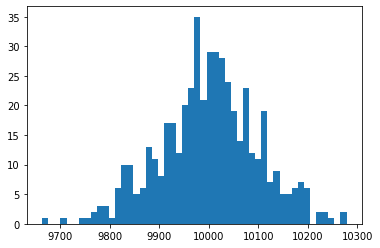

In [122]:
plt.hist(placar, bins=50)
plt.show()

And it looks quite randomly distributed in the graph ("Número de vitórias" --> "Number of winnings")

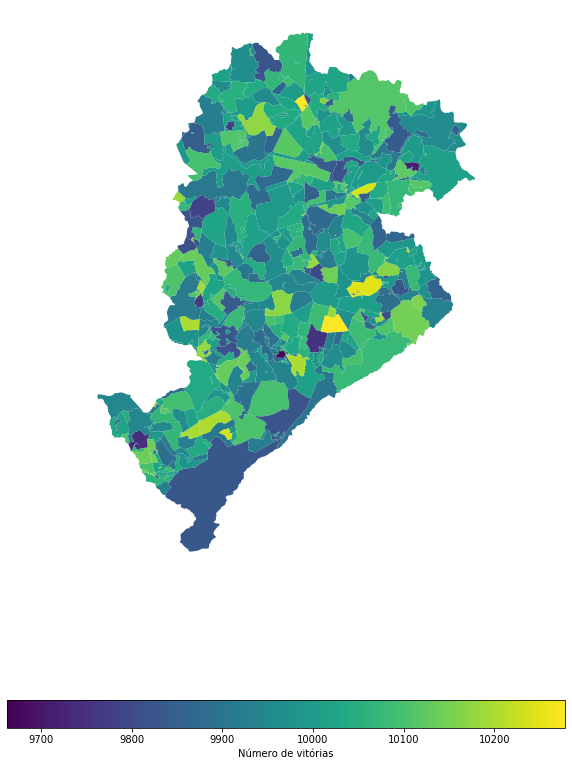

In [123]:
ggdf = gdf.copy()
ggdf['placar'] = placar

fig, ax = plt.subplots(1, 1, figsize=(10, 15))
ax.axis('off')

ggdf.plot(column='placar', ax=ax, legend=True,
        legend_kwds={'label': "Número de vitórias", 'orientation': "horizontal"})
plt.show()

I then compared it to the null distribution, same winning probability for every vertex. Giving this p-value, I can't really discard that there is no difference at all, which actually surprised me.

In [128]:
chisquare(placar)

Power_divergenceResult(statistic=480.61760000000004, pvalue=0.5603579400376466)